In [1]:
import graph_tool.all as gt
import sys, os
sys.path.append(os.path.abspath(os.path.join("libs/graph_embeddings")))
sys.path.append(os.path.abspath(os.path.join("libs/residual2vec")))
import graph_embeddings
import faiss
import residual2vec as rv
import numpy as np
import numpy as np
import pandas as pd
from scipy import sparse
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx

from sklearn.neighbors import kneighbors_graph
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA



Bad key "text.kerning_factor" on line 4 in
/home/ashutosh/miniconda3/envs/study/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
2022-07-26 17:20:17.618732: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-26 17:20:17.618910: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 17:20:17.619429: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using 

In [2]:
G = nx.read_gml("notebooks/2022_07_17_graph_reconstruction/data//polbooks.gml")
G = nx.relabel.convert_node_labels_to_integers(
    G, first_label=0, ordering="default"
)  # first_label is the starting integer label, in this case zero


In [3]:
#
# Randomize the graph by dcSBM
#
nodes = G.nodes(data=True)
labels, group_ids = np.unique([nd[1]["value"] for nd in nodes], return_inverse=True)
A = nx.adjacency_matrix(G).asfptype()


In [4]:
def dcSBM(A, group_membership):
    # Initalize the parameters
    n_nodes = A.shape[0]

    # Initialize the group membership
    if group_membership is None:
        group_membership = np.zeros(n_nodes, dtype=np.int64)
        node2group = rv.utils.to_member_matrix(group_membership)
    else:
        node2group = rv.utils.to_member_matrix(group_membership)

    indeg = np.array(A.sum(axis=0)).reshape(-1)
    probs = (node2group.T @ A @ node2group).toarray()
    gt_params = {
        "b": group_membership,
        "probs": probs,
        "micro_degs": True,
        "in_degs": indeg,
        "out_degs": indeg,
    }
    g = gt.generate_sbm(**gt_params)
    Ar = gt.adjacency(g).T
    Ar.data = np.ones_like(Ar.data)
    return Ar


In [5]:

# Ar = dcSBM(A, group_ids)
# A = Ar.copy()
# deg = np.array(Ar.sum(axis=1)).reshape(-1)
# G = nx.from_scipy_sparse_matrix(Ar)
deg = np.array(A.sum(axis=1)).reshape(-1)
G = nx.from_scipy_sparse_matrix(A)


In [6]:

# %%
# Embedding
#
models = {}
window_length = 5
num_walks = 10
dim = 128
models["Unbiased"] = model = graph_embeddings.DeepWalk(
    window_length=window_length, restart_prob=0, num_walks=num_walks
)

models["degree-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.ConfigModelNodeSampler(),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80,
)


In [7]:
# %%


class RandomEmbeddingSampler(rv.NodeSampler):
    """Node Sampler based on an embedding"""

    def __init__(self, model, randomizer, dim, k=10):
        """Node Sampler based on an embedding.
        Given a center node, a context node will be sampled with
        probability given by
        """

        # Reindex the group membership
        self.model = model
        self.dim = dim
        self.randomizer = randomizer
        self.k = k

    def fit(self, A):
        Ar = self.randomizer(A)
        self.model.fit(Ar)
        self.model.transform(self.dim)
        self.in_vec = self.model.in_vec.astype("float32")
        self.out_vec = self.model.out_vec.astype("float32")
        self.index = faiss.IndexFlatIP(self.dim)
        self.index.add(self.out_vec)
        self.k = np.minimum(A.shape[0], self.k)

        return self

    def sampling(self, center_nodes, context_nodes, padding_id):
        sim, indices = self.index.search(self.in_vec[center_nodes, :], k=int(self.k))
        sim = np.exp(sim)
        sim = np.einsum("ij,i->ij", sim, 1 / np.array(np.sum(sim, axis=1)).reshape(-1))
        sim = np.cumsum(sim, axis=1)
        retval = np.zeros(sim.shape[0], dtype=np.int64)
        for j in range(sim.shape[0]):
            retval[j] = int(indices[j, np.searchsorted(sim[j, :], np.random.rand())])
        return retval



In [8]:

base_model = rv.residual2vec_sgd(
    noise_sampler=rv.ConfigModelNodeSampler(),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80,
)
noise_sampler = RandomEmbeddingSampler(
    base_model, randomizer=lambda x: dcSBM(x, group_ids), dim=dim
)

models["group-unbiased"] = rv.residual2vec_sgd(
    # noise_sampler=noise_sampler,
    noise_sampler=rv.SBMNodeSampler(
        group_membership=group_ids, window_length=window_length
    ),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80,
)

In [9]:
# %%
# Embedding
#
embs = {}
for k, model in models.items():
    emb = model.fit(A).transform(dim=dim)
    embs[k] = emb


100%|█████████████████████████████████████████████████████████████████████████████████| 329/329 [00:00<00:00, 449.62it/s, loss=1.26]


In [10]:
def reconstruct_graph(emb, n, m):
    #    k = int(np.ceil(m / n))
    #    A = kneighbors_graph(emb, k, mode="distance", include_self=False, metric="cosine")
    #    A.data = 1 - A.data
    #    return nx.from_scipy_sparse_matrix(A)
    S = emb @ emb.T
    S = np.triu(S, k=1)
    r, c, v = sparse.find(S)
    idx = np.argsort(-v)[:m]
    r, c, v = r[idx], c[idx], v[idx]
    B = sparse.csr_matrix((v, (r, c)), shape=(n, n))
    B = B + B.T
    B.data = B.data * 0 + 1
    return nx.from_scipy_sparse_matrix(B + B.T)


In [11]:
n_edges = int(A.sum() / 2)
n_nodes = A.shape[0]
rgraphs = {}
for k, emb in embs.items():
    rgraphs[k] = reconstruct_graph(emb, n_nodes, n_edges)


In [12]:

X = embs["Unbiased"].copy()
X = np.hstack([X, deg.reshape((-1, 1))])
clf = LinearDiscriminantAnalysis(n_components=2, shrinkage=0.01, solver="eigen")
# xys = clf.fit_transform(X, group_ids)
xys = PCA(n_components=2).fit_transform(X)
# xys[:, 1] = deg/np.sum(deg)
pos = {i: xys[i, :] for i in range(xys.shape[0])}


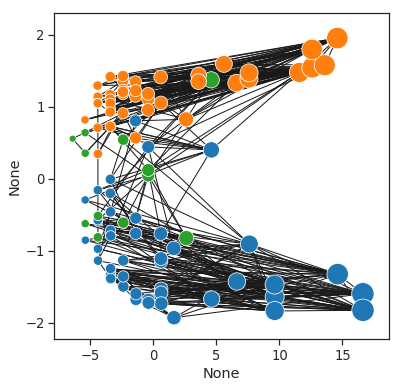

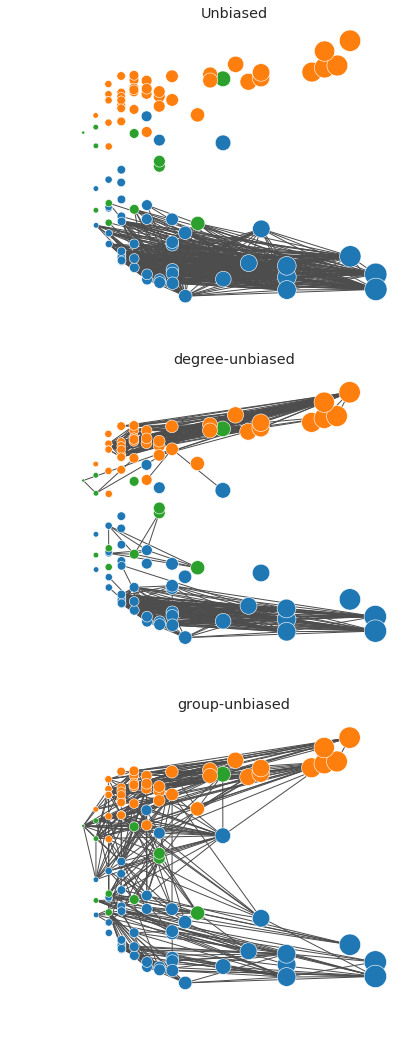

In [13]:
# %%
# Plot the original graph
#
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 6))

nx.draw_networkx_edges(G, pos, ax=ax)
sns.scatterplot(
    x=xys[:, 0],
    y=xys[:, 1],
    hue=group_ids,
    size=deg,
    sizes=(50, 500),
    palette="tab10",
    ax=ax,
)
# ax.axis("off")
ax.legend().remove()

fig.savefig("original_graph.pdf", bbox_inches="tight", dpi=300)
# %% Plot the reconstructed graphs
fig, axes = plt.subplots(figsize=(6, 6 * len(rgraphs)), nrows=len(rgraphs), ncols=1)

for i, (k, v) in enumerate(rgraphs.items()):
    ax = axes[i]
    weights = [rgraphs[k][u][v]["weight"] for u, v in rgraphs[k].edges()]
    nx.draw_networkx_edges(rgraphs[k], pos, ax=ax, edge_color="#4d4d4d")
    sns.scatterplot(
        x=xys[:, 0],
        y=xys[:, 1],
        hue=group_ids,
        size=deg,
        sizes=(10, 500),
        palette="tab10",
        ax=ax,
    )
    ax.axis("off")
    ax.legend().remove()
    ax.set_title(k)

fig.savefig("reconstructed_graph.pdf", bbox_inches="tight", dpi=300)


In [14]:
# %%
labels

array(['c', 'l', 'n'], dtype='<U1')

In [15]:
# %%
n_edges

441

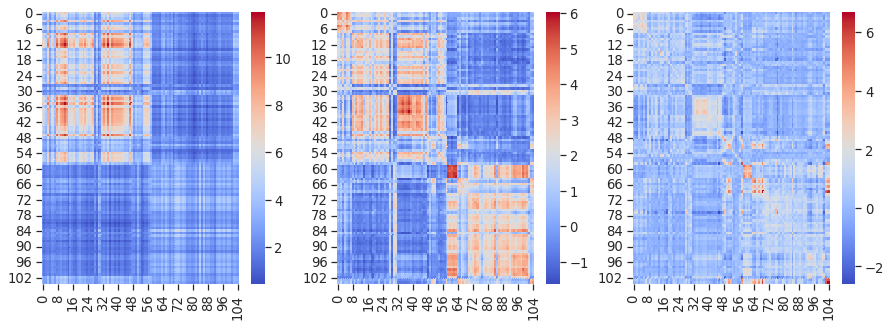

In [16]:
# %%
# %%
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

for i, (k, v) in enumerate(embs.items()):
    X = embs[k]
    ax = sns.heatmap(X @ X.T, ax=axes[i], cmap = "coolwarm")